This is the first in a series of notebooks designed for the "Hackathon" at the TESS Interactive Data Workshop taking place at the winter AAS meeting. 

The hackathon notebooks are intended to be a non-comprehensive guide on to how to approach different problems with TESS. It is up to the user to fill in the blanks to customize the notebook to their interests. Because of this, a basic knowledge of TESS data handling is prerequisite to these notebooks. 

If you are new to TESS, please first refer to the following tutorials before proceeding further.

MAST tutorials (also available on TIKE): https://github.com/spacetelescope/tike_content/blob/main/content/science-examples-github.md

lightkurve tutorials: https://docs.lightkurve.org/tutorials/index.html



In [1]:
%matplotlib inline

In [2]:
import lightkurve as lk
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np

In this notebook we will find and fit an exoplanet signal from the Full Frame Image (FFI) data. The FFI data contains the full set of science and collateral pixels across all CCDs of a given camera. In the primary mission, the full FFI was downloaded every 30 minutes. During the first mission extension, this increased to 10 minutes and in the second extension, which began in September 2022, a further increase was made so that FFIs are available at a 200-second cadence. 



# Step 1: search the FFIs for your favorite planet.

In the cell below, we will search for TESScut files, which are cutouts from the FFI around the target. 
Note that if you are interested in a specific sector of data, you can add "sector=XX" in the search call. 

The result will show all available data for the file. 
The search results contain 
- the mission (here the mission will be "TESS Sector XX"), 
- the year the observation was taken
- the author of the data (TESScut)
- the exposure time. Note for TESScut results, this is the actual exposure time and not the cadence (i.e., does not not include the time for exposured removed by cosmic ray mitigation)
- name of the target
- distance from your input target in arcsec

If the target was not observed or was recently observed but the data is not yet available, the search result will be empty


In [3]:
# Put your favorite exoplanet (or star) here
obj_name = 'WASP-186' 
# Note this notebook demonstrates how to generate lightcurves from scratch from FFIs. 
# However, this target also has pipeline-generated lightcurve products already. 
# If you are interested in seeing what lightcurve products exist, you can try lk.search_lightcurve(obj_name)
search_result = lk.search_tesscut(obj_name)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 17,2019,TESScut,1426,WASP-186,0.0
1,TESS Sector 42,2021,TESScut,475,WASP-186,0.0
2,TESS Sector 43,2021,TESScut,475,WASP-186,0.0
3,TESS Sector 57,2022,TESScut,158,WASP-186,0.0


Great, now lets pick one sector of data to look at.

From the FFI, we will create a target pixel file (TPF). You can specify the size of the cutout in pixels using cutout_size=X. If you provide an integer, the cutout will be square. You can also specify a rectangular cutout region in the format (y, x). 

Lightcurve makes it easy to plot the data using the plot method. To see all of the options for the plot, see the lightcurve API here: https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.plot.html

# Step 2: Create a Target Pixel File from the FFI

<Axes: title={'center': 'Target ID: WASP-186, Cadence: 500'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

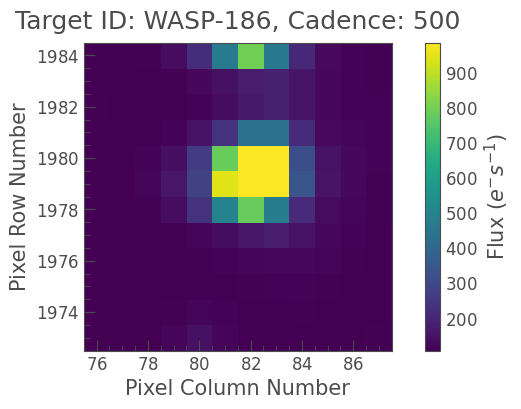

In [4]:
# Downloads a 12 pixel cutout region
tpf = search_result[1].download(cutout_size=(12,12))
tpf.plot(frame=500)

If all has gone well, you should now see your star above.

(Optional) If the star is in a crowded field, you may want to see what contaminants are in the area. We can use Gaia to find sources within our cutout region. If you are interested in that, fill out the next few cells. If not, skip ahead!

https://astroquery.readthedocs.io/en/latest/vizier/vizier.html

In [5]:
# We will query Vizier for the Gaia tables
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u

In [6]:
# Get the world coordinate system information from the tpf header you downloaded above
wcs = WCS(tpf.hdu[2].header)

In [7]:
# Here I use Vizier but there are also ways to query Gaia directly. Users choice!
v2 = Vizier(column_filters={"Gmag":'<20'})
# You can modify the search radius to reflect your tpf cutout size
catalogData = v2.query_object(obj_name, radius = (21*8)*u.arcsec, catalog='Gaia DR2')#['I/345/gaia2']
# Select the Gaia dr2 table (print catalogData here to see other catalog options)
catalogData = catalogData['I/345/gaia2']
catalogData

RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,mag,,,mag,mag,,,mag,mag,mag,km / s,km / s,K,mag,mag,solRad,solLum
float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
18.97125297060,0.3545,21.57776613723,0.2235,2790690562905245824,2.2623,0.3289,4.087,0.947,-3.585,0.452,0,568.9,2.087,18.8008,0.0040,158.8,35.03,19.8494,0.2395,696.9,11.18,17.6540,0.0174,2.1953,--,--,--,--,--,--,--
18.96879633418,0.9517,21.58075983395,0.5104,2790690562905246720,0.8165,0.8454,2.399,2.602,3.403,1.056,0,192.4,1.938,19.9782,0.0109,98.21,9.63,20.3710,0.1065,208.2,8.207,18.9655,0.0428,1.4055,--,--,--,--,--,--,--
19.02737022833,0.4127,21.61047686939,0.5412,2790690910798210944,0.0270,0.5204,5.097,1.110,-0.850,1.014,0,301.6,1.938,19.4899,0.0070,85.26,12.03,20.5245,0.1531,348.3,6.334,18.4070,0.0197,2.1175,--,--,--,--,--,--,--
19.01324556470,0.1085,21.62361569042,0.0820,2790691116956640128,1.7314,0.1210,25.569,0.220,-0.612,0.159,0,2762,3.151,17.0853,0.0012,900,19.43,17.9658,0.0234,2820,9.495,16.1362,0.0037,1.8296,--,--,--,--,--,--,--
19.00269872282,0.6178,21.63199338230,0.5485,2790691181384119424,3.2314,0.7139,-6.306,1.571,-12.638,1.198,0,219.8,1.764,19.8334,0.0087,48.41,5.519,21.1390,0.1238,335.8,18.89,18.4467,0.0611,2.6923,--,--,--,--,--,--,--
18.99531224274,0.0391,21.61690645507,0.0333,2790691147020786816,3.5621,0.0428,21.672,0.078,-9.221,0.068,0,1.035e+06,226.1,10.6509,0.0002,5.938e+05,455.9,10.9173,0.0008,6.37e+05,570.8,10.2516,0.0010,0.6657,-5.94,0.79,6262.25,0.5320,0.2783,1.51,3.164
19.02891465576,0.0422,21.62985339029,0.0359,2790691215740263296,0.9210,0.0462,0.009,0.088,-6.307,0.074,0,7.037e+05,448.5,11.0699,0.0007,3.146e+05,435.5,11.6071,0.0015,5.49e+05,650.6,10.4129,0.0013,1.1942,-19.78,0.50,4873.79,--,--,8.56,37.268
18.95321047405,0.0693,21.61166961098,0.0478,2790691494913762816,4.5608,0.0659,19.888,0.166,-29.686,0.099,0,7551,6.99,15.9933,0.0010,1784,30.03,17.2228,0.0183,9085,28.09,14.8661,0.0034,2.3566,--,--,3845.87,0.4760,0.2787,--,--


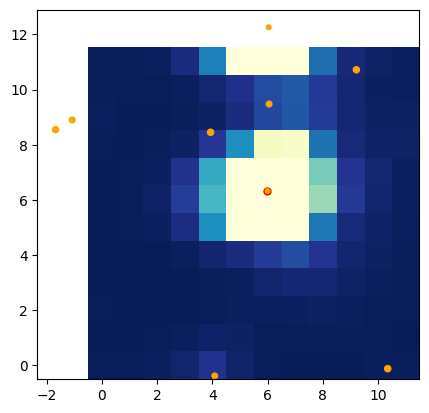

In [8]:
# Plot one of the tpf frames. 
image = tpf.hdu[1].data['FLUX'][500]
plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))


# Get the target star location and plot a red circle around it
starloc = wcs.all_world2pix([[tpf.hdu[1].header['RA_OBJ'],tpf.hdu[1].header['DEC_OBJ']]],0)  
plt.scatter(starloc[0,0], starloc[0,1],s = 25,color = 'red')


# Plot all nearby stars as well, which we created using our Catalog call in the previous cell.
nearbyLoc = wcs.all_world2pix(np.array([[x['RA_ICRS'], x['DE_ICRS']] for x in catalogData]),0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            #s = r['phot_g_mean_mag'][1:], color = 'orange')
            s = catalogData['Gmag'][1:], color = 'orange')

# Step 3: Create a Light Curve File 

The TPF and LC objects processed by the pipeline contain aperture information describing the pixels used to create the data product. Since you are cutting out a custom aperture from the FFI, you will need to define your own aperture. There are many ways to go about this, but here we demonstrate a simple threshold mask. Feel free to try other masking methods of your choice. You can also check out [this tutorial](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-1-custom-aperture-photometry.html) for more information.

In [9]:
# From the lightkurve API: threshold is a value for the number of sigma by which a pixel needs to be brighter than the median flux to be included in the aperture mask.
target_aperture = tpf.create_threshold_mask(threshold=10, reference_pixel='center')
n_target_pixels = target_aperture.sum()
n_target_pixels

17

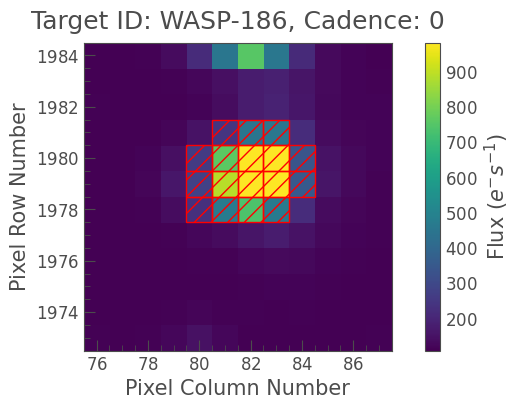

In [10]:
# Plot the tpf with the target aperture overplotted in red
tpf.plot(aperture_mask=target_aperture, mask_color='r');


Once you have an aperture you are happy with, you can easily turn it into a lightcurve.



<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

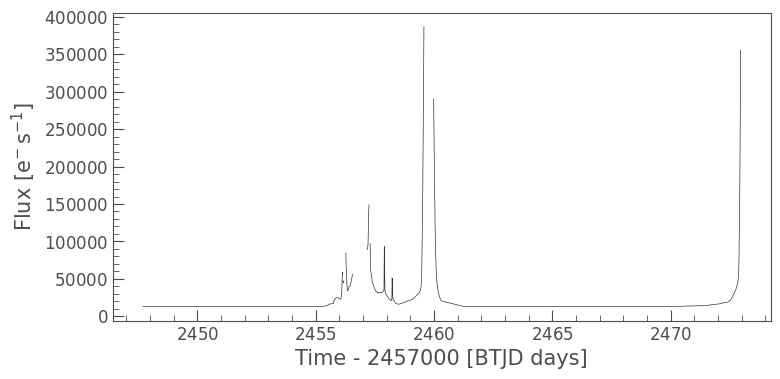

In [11]:
lc = tpf.to_lightcurve(aperture_mask=target_aperture)
lc.plot()

This is just the “Simple Aperture Photometry” (SAP) lightcurve and has no local background subtraction or other corrections. To create a background lightcurve, you can repeat the aperture creation step above but change the threshold values to find pixels without significant stellar flux. Feel free to play around with the background however you choose (different thresholds, removing pixels with Gaia sources found above, etc). You can also use tpf.interact_sky() to inspect Gaia sources from DR2 and tpf.interact() to play around with different apertures.  You can uncomment the below cells to try these options out. 

In [12]:
# tpf.interact_sky()

In [13]:
# tpf.interact()

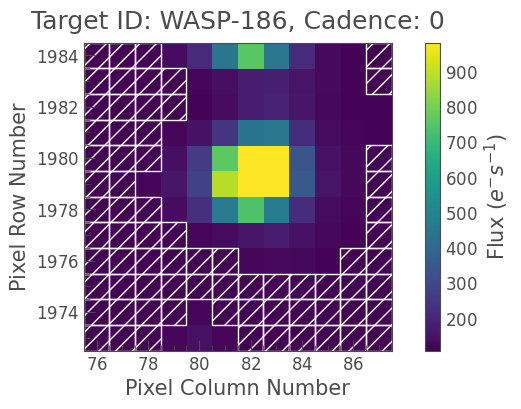

In [14]:
background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)
tpf.plot(aperture_mask=background_mask, mask_color='w');


Once you are happy with your target and background masks, we can correct for the background level

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

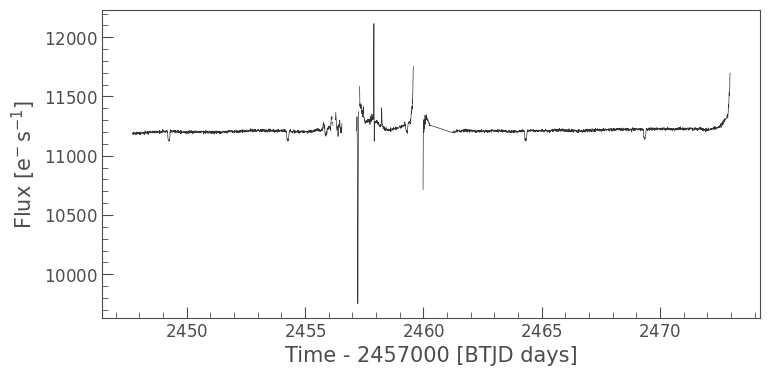

In [15]:

background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / np.sum(background_mask)
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Subtract out the background and plot
corrected_lc = lc - background_estimate_lc.flux
corrected_lc.plot()

Hopefully your lightcurve is looking reasonable at this point. In some cases there could still be some trouble areas. 

In the example shown here, there is obviously something going on in the middle of the sector. Let's explore that a bit before deciding what to do with this data. 

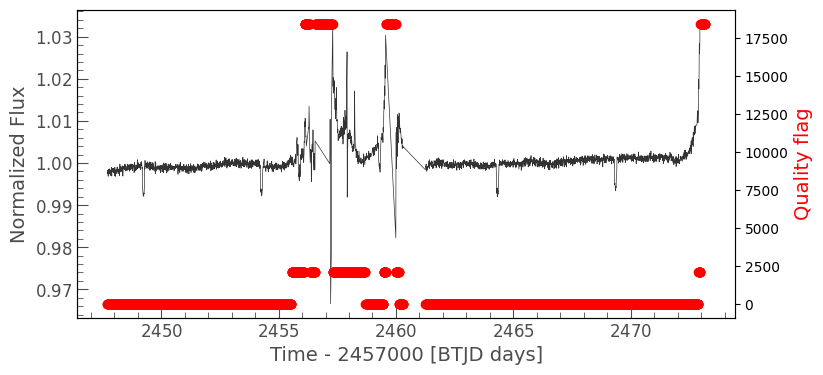

In [16]:
# Plot our corrected lightcurve
ax = corrected_lc.remove_outliers(sigma=10).normalize().plot()
ax.set_xlabel('Time - 2457000 [BTJD days]', fontsize=14)
ax.set_ylabel('Normalized Flux', fontsize=14)

ax2=ax.twinx()
# Make a plot with different y-axis using second axis object
# Here we plot the data quality flag for each time step
ax2.scatter(corrected_lc.time.value, corrected_lc.quality,color="red")
ax2.set_ylabel("Quality flag",color="red",fontsize=14)
plt.show()


Looks like there are some non-nominal quality flags. Lets print out what the quality flags that are present in your lightcurve actually mean with the handy decode function.

In [17]:
[print('%s: %s'%(x, lk.TessQualityFlags.decode(x))) for x in np.unique(corrected_lc.quality)]

0: []
2048: ['Straylight']
18432: ['Straylight', 'Bad Calibration Exclude']


[None, None, None]

We can see that there are some quality flags thrown during this period of time. This corresponds to Stray light from Earth to Moon in Camera FOV (Quality 2048) and a combination of Stray light and Bad calibration (18432 = 2048 + 16384). Check out more details on the quality flags [here](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview).

One easy option is to remove the data with any bad quality flag. The cadences just affected by straylight do not necessarily need to be thrown out like we do below, and there are various techniques to correct it. You can try your hand at correcting the data affected by stray light instead. Check out the [lightkurve tutorials](https://docs.lightkurve.org/tutorials/index.html) if you need inspiration. 

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

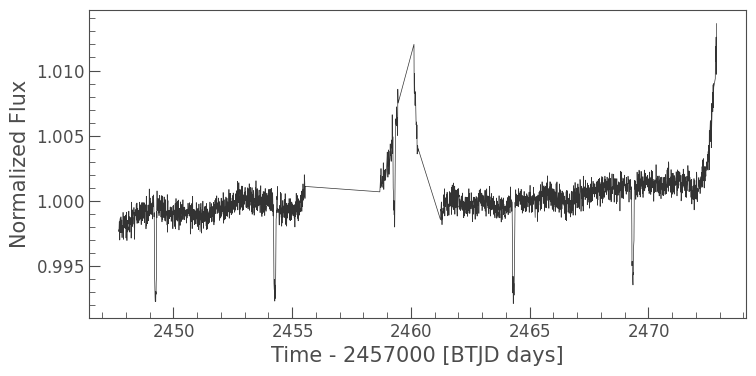

In [18]:
# Just throws out all flagged data
corrected_lc = corrected_lc[corrected_lc.quality == 0]
corrected_lc.normalize().plot()

For good measure we will also flatten this lightcurve to get rid of some of the variation in the lightcurve. We will just use the default paramaters for lightkurve's flatten function, but it is worth exploring other options as well. You can even check out different packages such as wotan for more flattening options. 

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

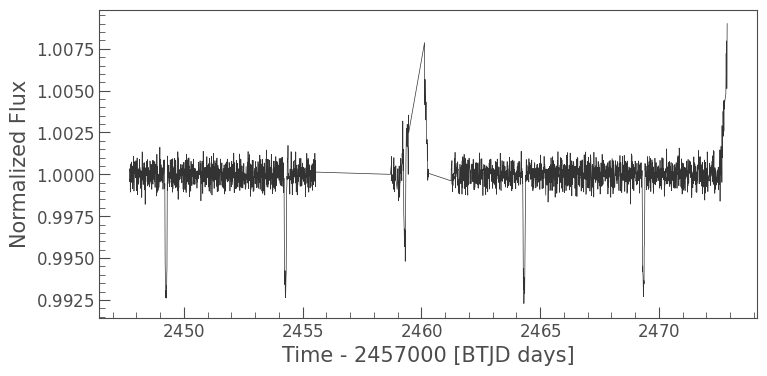

In [19]:
corrected_lc = corrected_lc.normalize().flatten()
corrected_lc.plot()

# Step 3: Look for a planet in your data

Once you are satisfied with your lightcurve, it is time to look for planets. There are several different search algorithms you can use for this. Here we will make use of the Box Least Square method that has been implemented in lightkurve. You can try out any other method of your choosing as well.

For more information on keywords for the BLS periodogram in lightkurve: http://docs.lightkurve.org/reference/api/lightkurve.periodogram.BoxLeastSquaresPeriodogram.from_lightcurve.html#lightkurve.periodogram.BoxLeastSquaresPeriodogram.from_lightcurve

Best fitting period: 5.027902790279028 d


<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

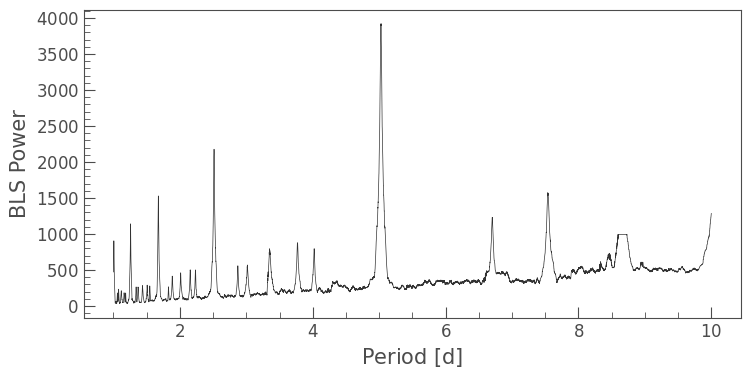

In [20]:
# Create array of periods to search. This is in units of your time, so here in days
period = np.linspace(1, 10, 10000)
bls = corrected_lc.to_periodogram(method='bls', period=period, frequency_factor=500)
print('Best fitting period: %s'%bls.period_at_max_power)
bls.plot()

(-0.5, 0.5)

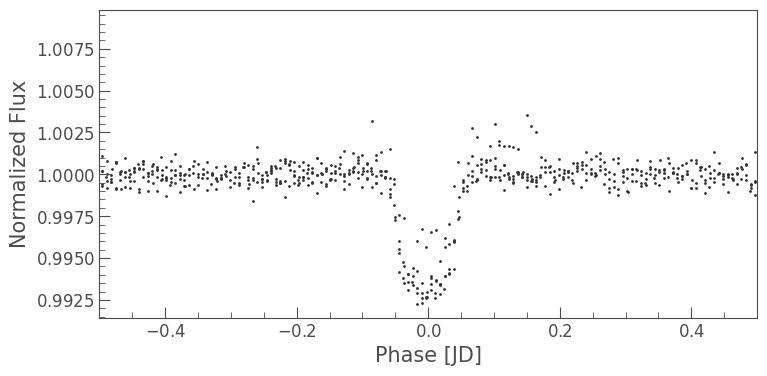

In [21]:
#Let's fold the lightcurve on the period of the largest signal
ax = corrected_lc.fold(period=bls.period_at_max_power, epoch_time=bls.transit_time_at_max_power).scatter()
ax.set_xlim([-.5,.5])

Tada! Now we have a nice lightcurve that we can use for any further transit modeling you want to do. 

Lets recap what we did in this notebook and look at ways to customize this to your needs.

1) Search for a star in the FFIs using either a known name or by coordinates. For this example, we only used one sector worth of data. 

2) Create a TPF from the FFI. The main variations here involve how you choose the aperture for the star and for the background. The decisions you make may change depending on considerations such as how crowded the field is. 

3) Create a LC from the TPF. This will require considerations such as background subtraction and quality flags as explored above. You may also want to look at, e.g., the cotrending basis vectors to get rid of systematic noise and different ways to flatten your data to correct for the stellar variability. 

4) Search for a planet signal. We just used a simple BLS here, but there are loads of options outside of the lightkurve package you can explore. 



Ideas for further exploration
- Pick your own interesting target and extract the lightcurve.
- Try stitching together multiple sectors of data to try to improve the transit signal. Note this can be tricky as different sectors can have different noise patterns.
- Explore how the different FFI cadences change planet detectability by looking for a planet that was observed with 30-minute, 10-minute and 200-second cadence and checking out how the transit fit changes.